This notebook simulates the inverse scattering algorithm

In [1]:
import numpy as np
import cProfile 
import torch
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from tqdm.notebook import tqdm
from components.channelmodel import ChannelModel
from components.invscattering import InverseScattering

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Inverse Scattering: Parameter Setting

In [2]:
# Parameters
num_pol = 2
num_segments = 5 # Num of concatination
num_freq_samples = num_segments*2


In [3]:
# Inverse Scattering

tau = 1 # group delay per segment 455 picoseconds
sps = 2 # This means we sample with fs = sps/tau 

# Channel Model Object
h_init = torch.eye(num_pol).to(torch.double)
chan_model = ChannelModel(num_segments=num_segments, num_pol=num_pol, h_init=h_init, device='cpu')
# Channel Params
true_params = chan_model.gen_rnd_channel_params() # it returns a dict with keys {'gamma','phi', 'psi', 'tau'}
true_params['tau'] = tau*torch.ones(num_segments).to(torch.double).to(device) # sets the tau to be the same for all sections (one of the ISA limitations)
true_params['gamma'] = 0.07+0.1*true_params['gamma'] # sets the PDL in range of  [0.3, 0.7] dB
(ht, hf) = chan_model.sample_freq_response_new(num_freq_samples, true_params)
# Inverse Scattering Model
inverse_scatering = InverseScattering(num_segments=num_segments, tau=tau) # Inverse Scattering Object
(h0_est,_,gamma_vec_est,phi_vec_est,psi_vec_est) = inverse_scatering.inverse_scattering(ht)

##### Rx channel response vs. inversed scattered channel response

Text(0.5, 0, 'time index')

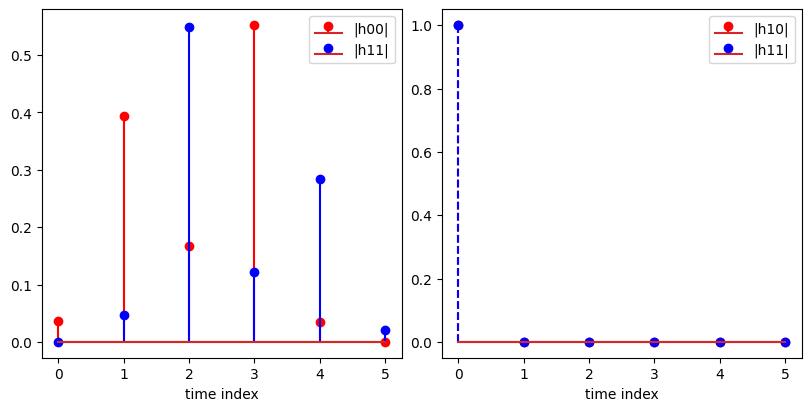

In [26]:
plt.figure(layout='constrained', figsize=(8, 4))

plt.subplot(1,2,1)
#c1 = torch.abs(h_rx[:,0,0]+h_rx[:,1,0])
#c2 = torch.abs(h_rx[:,1,1]+h_rx[:,0,1])
c1 = (torch.abs(ht[0:num_segments+1,0,0]))
c2 = (torch.abs(ht[0:num_segments+1,1,1]))
plt.stem(c1, linefmt='r-', label='|h00|')
plt.stem(c2, linefmt='b-', label='|h11|')
plt.xlabel('time index')
plt.legend()

plt.subplot(1,2,2)
t1 = torch.abs(h0_est[:,0,0] )
t2 = torch.abs(h0_est[:,1,1])
plt.stem(t1, linefmt='r--', label='|h10|')
plt.stem(t2, linefmt='b--', label='|h11|')
plt.legend()
plt.xlabel('time index')



## Estimated PDL, Phi, Psi

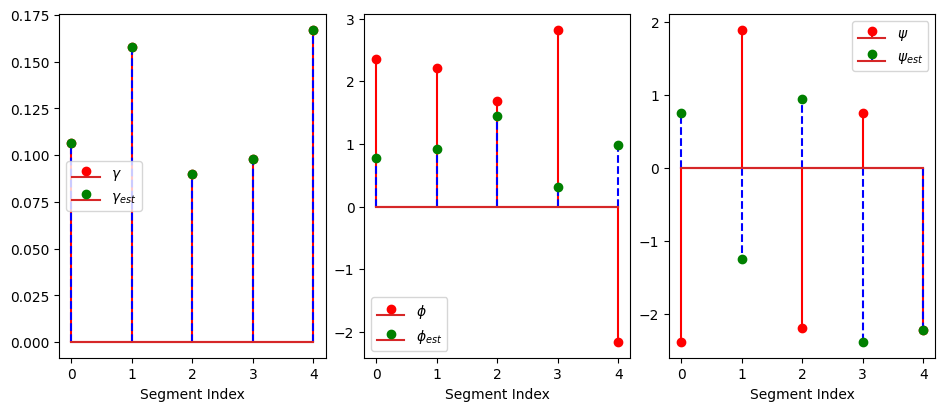

In [27]:
plt.figure(layout='constrained', figsize=(12, 4))

plt.subplot(1,4,1)
plt.stem(true_params['gamma'], linefmt='r-', label=r'$\gamma$')
plt.stem(gamma_vec_est, markerfmt='go', linefmt='b--', label=r'$\gamma_{est}$')
plt.xlabel('Segment Index')
plt.legend()

plt.subplot(1,4,2)
plt.stem(true_params['phi'], linefmt='r-', label=r'$\phi$')
plt.stem((phi_vec_est), markerfmt='go', linefmt='b--', label=r'$\phi_{est}$')
plt.xlabel('Segment Index')
plt.legend()

plt.subplot(1,4,3)
plt.stem(true_params['psi'], linefmt='r-', label=r'$\psi$')
plt.stem((psi_vec_est), markerfmt='go', linefmt='b--', label=r'$\psi_{est}$')
plt.xlabel('Segment Index')
plt.legend()


